<a href="https://colab.research.google.com/github/skywalker0803r/deep-learning-ian-goodfellow/blob/master/ADDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
from torch.autograd import Function
from torch import optim
from torch.utils.data import TensorDataset,DataLoader
from sklearn.preprocessing import  StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import xgboost
from sklearn.multioutput import MultiOutputRegressor
from sklearn.utils import shuffle
import warnings 
warnings.simplefilter('ignore')

# ADDA 

In [2]:
class ADDA(nn.Module):
  def __init__(self,src_x,src_y,tgt_x,tgt_y):
    super().__init__()
    '''
    src_x : 模擬數據的x type:pd.DataFrame()
    src_y : 模擬數據的y type:pd.DataFrame()
    tgt_x : 真實數據的x type:pd.DataFrame()
    tgt_y : 真實數據的y type:pd.DataFrame()
    '''
    
    # config
    self.x_col = src_x.columns.tolist()
    self.y_col = src_y.columns.tolist()
    self.α = 0.00005
    self.c = 0.01
    self.m = 64
    self.ncritic = 5
    self.input_dim = src_x.shape[1]
    self.output_dim = src_y.shape[1]
    
    # scaled feature
    self.scaler_x =  StandardScaler().fit(src_x.loc[:])
    src_x.loc[:] = self.scaler_x.transform(src_x.loc[:])
    tgt_x.loc[:] = self.scaler_x.transform(tgt_x.loc[:])
    
    # to torch.FloatTensor
    src_x,src_y = torch.FloatTensor(src_x.values),torch.FloatTensor(src_y.values)
    tgt_x,tgt_y = torch.FloatTensor(tgt_x.values),torch.FloatTensor(tgt_y.values)
    
    # make data_iter
    self.src_dataset = TensorDataset(src_x,src_y)
    self.tgt_dataset = TensorDataset(tgt_x,tgt_y)
    
    # src data encoder
    self.SRC_F = nn.Sequential(
        nn.Linear(self.input_dim,128),
        nn.ReLU(),
        nn.Linear(128,128),
        nn.ReLU(),
        )
    
    # target data encoder
    self.TGT_F = nn.Sequential(
        nn.Linear(self.input_dim,128),
        nn.ReLU(),
        nn.Linear(128,128),
        nn.ReLU(),
        )
    
    # regression model
    self.regression = nn.Sequential(
        nn.Linear(128,128),
        nn.ReLU(),
        nn.Linear(128,self.output_dim),
        )
    
    # discriminator or call critic
    self.discriminator = nn.Sequential(
        nn.Linear(128,128),
        nn.ReLU(),
        nn.Linear(128,1),# 1.判别器最后一层去掉sigmoid
    )

    # loss function
    self.reg_loss = nn.SmoothL1Loss() 
    
    # optimizer
    self.S_optimizer = optim.Adam(self.SRC_F.parameters(),lr=1e-3)
    self.R_optimizer = optim.Adam(self.regression.parameters(),lr=1e-3)

    # 不要用基于动量的优化算法（包括momentum和Adam），推荐RMSProp
    self.T_optimizer = optim.RMSprop(self.TGT_F.parameters(),lr=self.α)
    self.D_optimizer = optim.RMSprop(self.discriminator.parameters(),lr=self.α)
  
  def forward(self,src_x,tgt_x):
    src_feat,tgt_feat = self.SRC_F(src_x),self.TGT_F(tgt_x)
    src_reg,tgt_reg = self.regression(src_feat),self.regression(tgt_feat)
    src_domain,tgt_domain = self.discriminator(src_feat),self.discriminator(tgt_feat)
    return src_reg,src_domain,tgt_reg,tgt_domain
  
  def train_S_R(self,src_x,src_y):
    '''
    input : src_x(FloatTensor),src_y(FloatTensor)
    output : loss(Scalar)
    update_method : 一般監督學習
    '''
    
    self.SRC_F.train()
    self.regression.train()
    
    # forward
    src_feat = self.SRC_F(src_x)
    y_hat = self.regression(src_feat)
    
    # compute loss
    loss = self.reg_loss(y_hat,src_y).mean()
    loss.backward()
    
    # update weight
    self.S_optimizer.step()
    self.R_optimizer.step()
    self.S_optimizer.zero_grad()
    self.R_optimizer.zero_grad()
    
    return loss.item()
  
  def train_T_D(self,src_x,tgt_x,tgt_y):
    '''
    input: src_x(FloatTensor),tgt_x(FloatTensor),tgt_y(FloatTensor)
    return :d_loss(Scalar),t_loss(Scalar),r_loss(Scalar)
    '''
    # 2.生成器和判别器的loss不取log
    # train discriminator ncritic times
    for i in range(self.ncritic):
      src_feat = self.SRC_F(src_x).detach()
      tgt_feat = self.TGT_F(tgt_x).detach()
      d_loss = -torch.mean(self.discriminator(src_feat)) + torch.mean(self.discriminator(tgt_feat))
      d_loss.backward()
      self.D_optimizer.step()
      self.D_optimizer.zero_grad()
      # 每次更新判别器的参数之后把它们的绝对值截断到不超过一个固定常数c
      for p in self.discriminator.parameters():
        p.data.clamp_(-self.c,self.c)
    
    # train TGT_F
    tgt_feat = self.TGT_F(tgt_x)
    t_loss = -torch.mean(self.discriminator(tgt_feat))
    t_loss.backward()
    self.T_optimizer.step()
    self.T_optimizer.zero_grad()

    # train regression
    tgt_reg = self.regression(tgt_feat.detach())
    r_loss = self.reg_loss(tgt_reg,tgt_y).mean()
    r_loss.backward()
    self.R_optimizer.step()
    self.R_optimizer.zero_grad()
    
    return d_loss.item(),t_loss.item(),r_loss.item()

  def get_predict(self,tgt_x):
    '''
    input: pd.DataFrame()
    output: pd.DataFrame()
    '''
    tgt_x = self.scaler_x.transform(tgt_x)
    tgt_x = torch.FloatTensor(tgt_x)
    tgt_feat = self.TGT_F(tgt_x)
    tgt_reg = self.regression(tgt_feat).detach().cpu().numpy()
    tgt_reg = pd.DataFrame(tgt_reg,columns=self.y_col)
    return tgt_reg

# Load Data

In [3]:
src_data = shuffle(pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/phase1/train_4565.csv',index_col=0))
tgt_data = shuffle(pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/phase1/test_250.csv',index_col=0))

# get columns_name
x_col = ['T10','T50','T90','N+A']
y_col = src_data.drop(x_col,axis=1).columns.tolist()

# split some data for final testing
tgt_data,final_test_data = tgt_data.iloc[:200],tgt_data.iloc[200:]

# instance ADDA model

In [4]:
src_x,src_y = src_data[x_col],src_data[y_col]
tgt_x,tgt_y = tgt_data[x_col],tgt_data[y_col]
model = ADDA(src_x,src_y,tgt_x,tgt_y)

# Fit Xgboost

In [5]:
xgb_200 = MultiOutputRegressor(xgboost.XGBRegressor(objective='reg:squarederror')).fit(tgt_x,tgt_y)
xgb_4765 = MultiOutputRegressor(xgboost.XGBRegressor(objective='reg:squarederror')).fit(src_x.append(tgt_x),src_y.append(tgt_y))

# ADDA train stage_1

ep:0 loss:3.8840928077697754
ep:100 loss:0.40487363934516907
ep:200 loss:0.18765291571617126
ep:300 loss:0.15297380089759827
ep:400 loss:0.16754485666751862
ep:500 loss:0.1709720939397812
ep:600 loss:0.16203069686889648
ep:700 loss:0.221551775932312
ep:800 loss:0.17149117588996887
ep:900 loss:0.09843682497739792


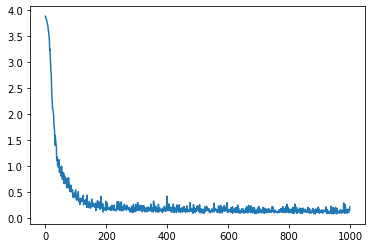

In [6]:
history = []
for ep in range(1000):
  idx = random.sample([*range(len(model.src_dataset))],model.m)
  src_x,src_y = model.src_dataset[idx]
  loss = model.train_S_R(src_x,src_y)
  history.append(loss)
  if ep % 100 == 0:
    print("ep:{} loss:{}".format(ep,loss))
plt.plot(history)

# ADDA train_stage_2

ep:0 d_loss:-0.03084426373243332 t_loss:-0.015305502340197563 r_loss:2.865492343902588
ep:100 d_loss:-0.17032447457313538 t_loss:-0.4123603105545044 r_loss:0.609425961971283
ep:200 d_loss:-0.0033254027366638184 t_loss:-0.4949823021888733 r_loss:0.4404541850090027
ep:300 d_loss:-0.0491095632314682 t_loss:-0.16933655738830566 r_loss:0.4018411934375763
ep:400 d_loss:-0.10963507741689682 t_loss:0.06555694341659546 r_loss:0.3944481611251831
ep:500 d_loss:-0.10729271173477173 t_loss:0.09196837246417999 r_loss:0.36927422881126404
ep:600 d_loss:-0.07469300180673599 t_loss:-0.0893351286649704 r_loss:0.2921070158481598
ep:700 d_loss:-0.08219291269779205 t_loss:-0.036757320165634155 r_loss:0.3306017518043518
ep:800 d_loss:-0.07445662468671799 t_loss:-0.0006200114730745554 r_loss:0.27642184495925903
ep:900 d_loss:-0.08065127581357956 t_loss:-0.01012138556689024 r_loss:0.2778342366218567
ep:1000 d_loss:-0.05608459562063217 t_loss:-0.07543200999498367 r_loss:0.30768877267837524
ep:1100 d_loss:-0.067

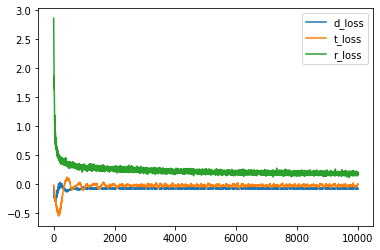

In [7]:
d_history = []
t_history = []
r_history = []
for ep in range(10000):
  tgt_idx = random.sample([*range(len(model.tgt_dataset))],model.m)
  src_idx = random.sample([*range(len(model.src_dataset))],model.m)
  tgt_x,tgt_y = model.tgt_dataset[tgt_idx]
  src_x,src_y = model.src_dataset[src_idx]
  d_loss,t_loss,r_loss = model.train_T_D(src_x,tgt_x,tgt_y)
  d_history.append(d_loss)
  t_history.append(t_loss)
  r_history.append(r_loss)
  if ep % 100 == 0:
    print("ep:{} d_loss:{} t_loss:{} r_loss:{}".format(ep,d_loss,t_loss,r_loss))

plt.plot(d_history,label='d_loss')
plt.plot(t_history,label='t_loss')
plt.plot(r_history,label='r_loss')
plt.legend()
plt.show()

# model predict

In [8]:
x_test = final_test_data[x_col]
y_test = final_test_data[y_col]

In [9]:
adda_y_hat = model.get_predict(x_test)
xgb_200_y_hat = pd.DataFrame(xgb_200.predict(x_test),columns=y_col)
xgb_4765_y_hat = pd.DataFrame(xgb_4765.predict(x_test),columns=y_col)

# evaluate

In [10]:
from sklearn.metrics import r2_score,mean_squared_error

def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def show_metrics(y_pred,y_real):
  res = pd.DataFrame(index=y_pred.columns,columns=['R2','RMSE','MAPE'])
  for i in y_pred.columns:
    res.loc[i,'R2'] = r2_score(y_real[i],y_pred[i])
    res.loc[i,'RMSE'] = np.sqrt(mean_squared_error(y_real[i],y_pred[i]))
    res.loc[i,'MAPE'] = mape(y_real[i],y_pred[i])
  res.loc['AVG'] = res.mean(axis=0)
  return res

In [11]:
adda_res = show_metrics(adda_y_hat,y_test)
adda_res

,R2,RMSE,MAPE
C5NP,0.902538,1.25575,38.9095
C5IP,0.900309,0.926598,40.1832
C5N,0.799522,0.145865,75.6348
C6NP,0.812856,0.867869,27.999
C6IP,0.849795,1.03749,15.8521
C6N,0.589166,1.39841,10.2791
C6A,0.68649,0.635801,79.389
C7NP,0.493562,0.661023,8.15568
C7IP,0.663651,0.907484,10.6698
C7N,0.920971,1.48458,7.55333


In [12]:
xgb_200_res = show_metrics(xgb_200_y_hat,y_test)
xgb_200_res

,R2,RMSE,MAPE
C5NP,-0.452921,4.8485,233.79
C5IP,-0.832056,3.97221,128.882
C5N,-0.874386,0.446012,276.009
C6NP,-2.46932,3.7367,165.178
C6IP,-1.78551,4.4678,272.904
C6N,-1.8923,3.71041,52.1214
C6A,-0.530952,1.405,79.1569
C7NP,-4.74467,2.22631,34.6897
C7IP,-1.7293,2.58505,31.8675
C7N,-1.037,7.53713,62.005


In [13]:
xgb_4765_res = show_metrics(xgb_4765_y_hat,y_test)
xgb_4765_res

,R2,RMSE,MAPE
C5NP,-0.820174,5.42679,141.057
C5IP,-0.696569,3.82251,163.471
C5N,-1.20075,0.483284,222.674
C6NP,-2.17363,3.57392,178.461
C6IP,-1.627,4.33882,298.058
C6N,-2.7528,4.22647,59.7765
C6A,-13.7376,4.35922,1134.21
C7NP,-12.9107,3.4644,58.9349
C7IP,-3.31726,3.25123,46.0181
C7N,-1.41415,8.20527,39.5093


In [16]:
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Bar(name='ADDA', x=y_col, y=adda_res['RMSE']),
    go.Bar(name='XGB_200', x=y_col, y=xgb_200_res['RMSE']),
    go.Bar(name='XGB_4765', x=y_col ,y=xgb_4765_res['RMSE']),
])
# Change the bar mode
fig.update_layout(barmode='group',title='RMSE')
fig.show()

In [15]:
\